In [1]:
"""

Description:
This script performs the complete data pipeline for analyzing and modeling hospital bed utilization rates
using social determinants of health (SDOH) and geographic access features. The workflow includes:

1. Data Loading and Initial Exploration
2. Preprocessing and Filtering (e.g., region/state exclusions, missing data handling)
3. Feature Engineering:
   - One-hot encoding of Region
   - Target encoding of State
   - Binary encoding for Is_Metro_Micro
   - Imputing for target variable using MICE
4. Testing accuracy of true vs imputed values for Bed_util_ratio
Inputs:
- `MERGED_SDOH_PLUS_UTIL_20_RenamedColumns.csv`: Raw merged dataset with renamed variables

Outputs:
- `final data set with encoded variables and imputed applied where approriate except for Is_Metro_Micro


Note:
- Target variable: `Bed_util_ratio`
- Special handling applied to: `Is_Metro_Micro`, `State`, and `Region`
- Target variable should not be imputed - we reject this method
"""
import pandas as pd
import numpy as np
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
file_path = r'C:\Users\reake\OneDrive\Documents\rea new\Data science capstone\week 4\MERGED_SDOH_PLUS_UTIL_20_RenamedColumns.csv'
df = pd.read_csv(file_path)

# Remove rows where CountyFIPS is in the list
fips_to_remove = [2080, 2210, 2280, 69000, 2120]
df = df[~df['CountyFIPS'].isin(fips_to_remove)]

# Drop rows where Region is null or blank
df = df[df['Region'].notna()]
df = df[df['Region'].str.strip() != '']

# One-hot encode Region
df_encoded = pd.get_dummies(df, columns=['Region'])
region_cols = [col for col in df_encoded.columns if col.startswith('Region_')]
df_encoded[region_cols] = df_encoded[region_cols].astype(int)

# Drop County column
df = df.drop(columns=['County'])
df_encoded = df_encoded.drop(columns=['County'])

# Count encode State
state_counts = df['State'].value_counts()
df_encoded['State_Count'] = df_encoded['State'].map(state_counts)

# Target encode State
state_target_mean = df.groupby('State')['Bed_util_ratio'].mean()
df_encoded['State_target'] = df_encoded['State'].map(state_target_mean)

# Binary encode is_metro_micro
df_encoded['Is_Metro_Micro'] = df_encoded['Is_Metro_Micro'].map({True: 1, False: 0})

######################### MICE IMPUTATION ####################################

# Select features for imputation
features_for_imputation = df_encoded[[
    'Bed_util_ratio',
    'Pct_disabled',
    'Pct_age_65plus',
    'Pct_single_parent',
    'Median_hh_income',
    'Pct_hh_65_alone',
    'Pct_mobile_homes',
    'Pct_owner_cost_30plus',
    'Pct_renter_cost_30pct_plus',
    'Pct_renter_cost_50pct_plus',
    'Pct_renter_occupied',
    'Pct_homes_no_vehicle',
    'Pct_public_transit',
    'Land_area_sqmi',
    'Population_density',
    'Distance_to_ED',
    'Distance_to_medsurge_icu'
]].copy()

#making sure none of the values are negative
features_for_imputation = features_for_imputation.clip(lower=0)

# Create imputer with gradient boosting regressor
estimator = HistGradientBoostingRegressor(random_state=0)
imputer = IterativeImputer(estimator=estimator, max_iter=10, random_state=0)

# Impute
imputed_array = imputer.fit_transform(features_for_imputation)

# Add imputed column to df_encoded
df_encoded['Bed_util_ratio_imputed'] = imputed_array[:, 0]
df_encoded['Bed_util_ratio_imputed'] = df_encoded['Bed_util_ratio_imputed'].clip(lower=0)

# Drop original Bed_util_ratio column
df_encoded = df_encoded.drop(columns=['Bed_util_ratio'])

In [2]:
######################### TEST IMPUTATION ACCURACY ###########################

# Make a copy for testing
df_test = df_encoded.copy()

# We need to recover original 'Bed_util_ratio' for testing — so re-add it
df_test['Bed_util_ratio'] = features_for_imputation['Bed_util_ratio']

# Randomly mask 10% of known values, ensuring the mask is within bounds
non_null_mask = df_test['Bed_util_ratio'].notna()
to_mask = df_test[non_null_mask].sample(frac=0.1, random_state=42).index

# Check if the number of rows to mask exceeds available rows
to_mask = to_mask[to_mask < len(df_test)]  # Ensure we do not exceed available rows

# Store true values for evaluation later
true_values = df_test.loc[to_mask, 'Bed_util_ratio']

# Mask those values (set to NaN)
df_test.loc[to_mask, 'Bed_util_ratio'] = np.nan

# Prepare test features
features_test = df_test[[
    'Bed_util_ratio',
    'Pct_disabled',
    'Pct_age_65plus',
    'Pct_single_parent',
    'Median_hh_income',
    'Pct_hh_65_alone',
    'Pct_mobile_homes',
    'Pct_owner_cost_30plus',
    'Pct_renter_cost_30pct_plus',
    'Pct_renter_cost_50pct_plus',
    'Pct_renter_occupied',
    'Pct_homes_no_vehicle',
    'Pct_public_transit',
    'Land_area_sqmi',
    'Population_density',
    'Distance_to_ED',
    'Distance_to_medsurge_icu'
]].clip(lower=0)

# Impute again
imputed_array_test = imputer.fit_transform(features_test)
imputed_values = imputed_array_test[to_mask, 0]

# Evaluation
mae = mean_absolute_error(true_values, imputed_values)
rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")


MAE: 0.1283
RMSE: 0.1715


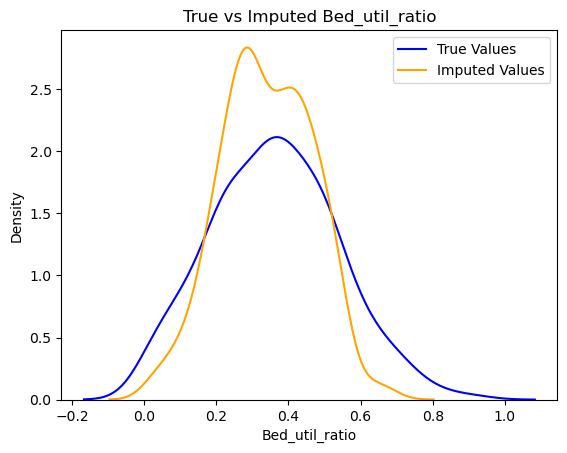

In [3]:
#distributions of true and imputed values
sns.kdeplot(true_values, label="True Values", color='blue')
sns.kdeplot(imputed_values, label="Imputed Values", color='orange')
plt.title("True vs Imputed Bed_util_ratio")
plt.legend()
plt.show()